In [6]:
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from category_encoders import TargetEncoder
import os
import warnings
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [7]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

In [8]:
input_dir = '../Codes/'
file_train = 'train_preprocessed.csv'
file_test = 'test_preprocessed.csv'
train_data = pd.read_csv(os.path.join(input_dir, file_train),index_col=None)
test_data = pd.read_csv(os.path.join(input_dir, file_test),index_col=None)

In [9]:
train_data

,bant_submit,com_reg_ver_win_rate,customer_idx,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,lead_desc_length,customer_position,...,continent_Europe,continent_North America,continent_Oceania,continent_South America,continent_others,business_unit_AS,business_unit_CM,business_unit_ID,business_unit_IT,business_unit_Solution
0,1.00,0.066667,0.000034,0,4.0,0.0,0.0,0,0.048298,0.037370,...,False,False,False,False,False,True,False,False,False,False
1,1.00,0.066667,0.000067,0,12.0,0.0,0.0,0,0.075218,0.134640,...,False,False,False,False,False,True,False,False,False,False
2,1.00,0.088889,0.000051,0,144.0,0.0,0.0,0,0.043547,0.042766,...,False,False,False,False,False,True,False,False,False,False
3,1.00,0.088889,0.000017,0,4.0,0.0,0.0,0,0.034046,0.134640,...,False,False,False,False,False,True,False,False,False,False
4,1.00,0.088889,0.000017,0,4.0,0.0,0.0,0,0.076010,0.042766,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,0.000000,0.000034,1,4.0,0.0,0.0,0,0.157561,0.037370,...,True,False,False,False,False,True,False,False,False,False
59295,0.75,0.040000,0.000017,0,4.0,0.0,0.0,0,0.054632,0.014317,...,False,False,False,True,False,True,False,False,False,False
59296,0.75,0.040000,0.000017,0,4.0,0.0,0.0,0,0.026128,0.037370,...,False,False,False,True,False,True,False,False,False,False
59297,1.00,0.040000,0.000017,0,4.0,0.0,0.0,0,0.297704,0.016257,...,False,False,False,True,False,True,False,False,False,False


## 데이터분리

In [10]:
train_data_target = pd.DataFrame(train_data['is_converted'])
train_data_feature = train_data.drop(columns='is_converted')

test_data_target = pd.DataFrame(test_data['is_converted'])
test_data_feature = test_data.drop(columns='is_converted')


# 데이터 분할 (0.8:0.2 비율로 분리)
X_train, X_test, y_train, y_test = train_test_split(train_data_feature, train_data_target, test_size=0.2, random_state=42)

In [11]:
from imblearn.over_sampling import SMOTE

# SMOTE를 사용하여 오버샘플링을 적용한 훈련 데이터 생성
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(train_data_feature, train_data_target)


## 하이퍼 파라미터 튜닝

In [19]:
import optuna
import xgboost as xgb
# Optuna를 위한 목적 함수
def objective(trial):
    # 탐색할 하이퍼파라미터 설정
    param = {
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1),
        'gamma': trial.suggest_loguniform('gamma', 1e-6, 1e-1),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12)
    }

    # 모델 생성 및 학습
    model = xgb.XGBClassifier(**param)
    model.fit(X_train_resampled, y_train_resampled)

    # 예측 및 평가
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='binary')

    return score

# Optuna Study 생성 및 최적화
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

# 최적화 결과 출력
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-08 13:12:29,778] A new study created in memory with name: no-name-d783be51-1620-4347-91ae-226ae43ceabc
[I 2024-02-08 13:12:32,144] Trial 0 finished with value: 0.7364378300528085 and parameters: {'n_estimators': 298, 'alpha': 0.0008449150404974651, 'gamma': 1.3384837123785323e-05, 'learning_rate': 0.09162324831793674, 'max_depth': 4}. Best is trial 0 with value: 0.7364378300528085.
[I 2024-02-08 13:12:34,672] Trial 1 finished with value: 0.7698706099815157 and parameters: {'n_estimators': 123, 'alpha': 0.0002513112477995799, 'gamma': 0.06671670535720144, 'learning_rate': 0.015980956611109376, 'max_depth': 11}. Best is trial 1 with value: 0.7698706099815157.
[I 2024-02-08 13:12:36,110] Trial 2 finished with value: 0.6892502258355917 and parameters: {'n_estimators': 113, 'alpha': 0.0001912832003142894, 'gamma': 0.004506464705529175, 'learning_rate': 0.0119497994374295, 'max_depth': 8}. Best is trial 1 with value: 0.7698706099815157.


Number of finished trials: 3
Best trial: {'n_estimators': 123, 'alpha': 0.0002513112477995799, 'gamma': 0.06671670535720144, 'learning_rate': 0.015980956611109376, 'max_depth': 11}


## 중요도 측정

XGBClassifier(alpha=0.0002513112477995799, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.06671670535720144, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.015980956611109376,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=123, n_jobs=None,
              num_parallel_tree=None, ...)

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 26 artists>

([<matplotlib.axis.YTick at 0x229d7e499a0>,
 [Text(0, 0, 'lead_owner'),
  Text(0, 1, 'lead_desc_length'),
  Text(0, 2, 'customer_idx'),
  Text(0, 3, 'response_corporate'),
  Text(0, 4, 'customer_position'),
  Text(0, 5, 'bant_submit'),
  Text(0, 6, 'com_reg_ver_win_rate'),
  Text(0, 7, 'historical_existing_cnt'),
  Text(0, 8, 'ver_win_ratio_per_bu'),
  Text(0, 9, 'enterprise'),
  Text(0, 10, 'business_unit_AS'),
  Text(0, 11, 'continent_Asia'),
  Text(0, 12, 'business_unit_ID'),
  Text(0, 13, 'ver_cus'),
  Text(0, 14, 'continent_Europe'),
  Text(0, 15, 'continent_others'),
  Text(0, 16, 'continent_South America'),
  Text(0, 17, 'continent_North America'),
  Text(0, 18, 'business_unit_IT'),
  Text(0, 19, 'id_strategic_ver'),
  Text(0, 20, 'ver_pro'),
  Text(0, 21, 'idit_strategic_ver'),
  Text(0, 22, 'it_strategic_ver'),
  Text(0, 23, 'continent_Africa'),
  Text(0, 24, 'continent_Oceania'),
  Text(0, 25, 'business_unit_Solution')])

Text(0.5, 0, 'Importance')

Text(0.5, 1.0, 'Feature Importances')

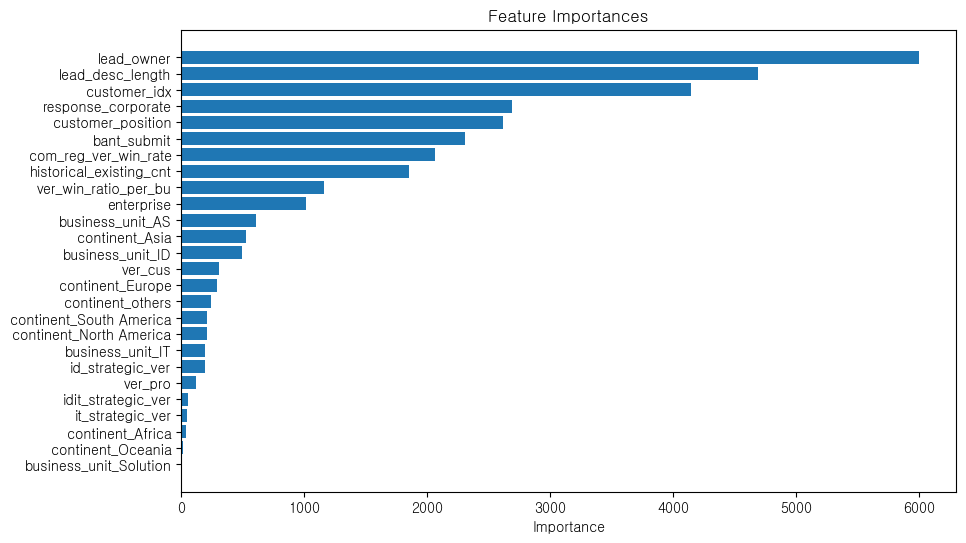

In [20]:
final_model = xgb.XGBClassifier(**study.best_trial.params)
final_model.fit(X_train_resampled, y_train_resampled)
y_pred_test = final_model.predict(test_data_feature)
# Get feature importances
# Get feature importances
feature_importances = final_model.get_booster().get_score(importance_type='weight')

# Prepare data for plotting
features = list(feature_importances.keys())
importances = list(feature_importances.values())
indices = range(len(importances))

# Sort the feature importances in descending order
sorted_idx = [i[0] for i in sorted(enumerate(importances), key=lambda x:x[1], reverse=True)]
sorted_features = [features[i] for i in sorted_idx]
sorted_importances = [importances[i] for i in sorted_idx]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [21]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
y_pred_test_bool = np.where(y_pred_test == 1, True, False)
df_sub = pd.read_csv("../Database/submission.csv")
df_sub["is_converted"] = y_pred_test_bool
df_sub.to_csv("submission.csv", index=False)
df_sub["is_converted"].value_counts()

is_converted
False    4078
True     1193
Name: count, dtype: int64